In [7]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"XXXX","key":"XXXX"}' > ~/.kaggle/kaggle.json
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

 99%|██████████████████████████████████████▌| 1.06G/1.07G [00:10<00:00, 116MB/s]
100%|███████████████████████████████████████| 1.07G/1.07G [00:10<00:00, 106MB/s]


In [1]:
# If running in Google Colab
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


In [0]:
!unzip -qo the-simpsons-characters-dataset.zip -d the-simpsons-characters-dataset
!cd the-simpsons-characters-dataset
!unzip -qo simpsons_dataset.zip -d the-simpsons-characters-dataset/
!unzip -qo kaggle_simpson_testset.zip -d the-simpsons-characters-dataset/

!rm ./the-simpsons-characters-dataset/kaggle_simpson_testset/.DS_Store
!rm ./the-simpsons-characters-dataset/simpsons_dataset/nelson_muntz/.DS_Store

In [14]:
from os import listdir

#configure train dataset
train_root_path = "./the-simpsons-characters-dataset/simpsons_dataset"
character_directories = listdir(train_root_path)
#character_directories.remove('.DS_Store')
print("Train: {}".format(character_directories[:5]))

#configure test dataset
test_root_path = "./the-simpsons-characters-dataset/kaggle_simpson_testset"
test_image_names = listdir(test_root_path)
#test_image_names.remove('.DS_Store')
print("Test: {}".format(test_image_names[:5]))


Train: ['jasper_beardly', 'martin_prince', 'edna_krabappel', 'hans_moleman', 'barney_gumble']
Test: ['abraham_grampa_simpson_43.jpg', 'lisa_simpson_2.jpg', 'nelson_muntz_27.jpg', 'mayor_quimby_21.jpg', 'principal_skinner_2.jpg']


### Calculate mean width and lenght from test images

In [15]:
import os, random
from scipy.misc import imread, imresize

width = 0
lenght = 0
num_test_images = len(test_image_names)

for i in range(num_test_images):
    path_file = os.path.join(test_root_path, test_image_names[i])
    image = imread(path_file)
    width += image.shape[0]
    lenght += image.shape[1]

width_mean = width//num_test_images
lenght_mean = lenght//num_test_images
dim_size = (width_mean + lenght_mean) // 2

print("Width mean: {}".format(width_mean))
print("Lenght mean: {}".format(lenght_mean))
print("Size mean dimension: {}".format(dim_size))

Width mean: 152
Lenght mean: 147
Size mean dimension: 149


Size mean dimension will be used for the resizing process. __All the images will be scaled__ to __(149, 149)__ since it's the average of the test images.

### Show some test examples

Label:apu_nahasapeemapetilon, Image:759, Shape:(171, 229, 3)


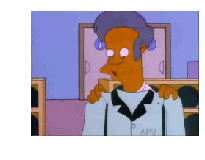

In [17]:
import matplotlib.pyplot as plt

idx = random.randint(0, num_test_images)
sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
path_file = os.path.join(test_root_path, sample_file)
sample_image = imread(path_file)

print("Label:{}, Image:{}, Shape:{}".format('_'.join(sample_name), idx, sample_image.shape))
plt.figure(figsize=(3,3))
plt.imshow(sample_image)
plt.axis('off')
plt.show()

### Making batches (resized)

In [0]:
def get_num_of_samples():
    count = 0
    for _,character in enumerate(character_directories):
        path = os.path.join(train_root_path, character)
        count += len(listdir(path))
        
    return count

def get_batch(batch_init, batch_size):
    data = {'image':[], 'label':[]}
    character_batch_size = batch_size//len(character_directories)
    character_batch_init = batch_init//len(character_directories)
    character_batch_end = character_batch_init + character_batch_size
    
    for _,character in enumerate(character_directories):
        path = os.path.join(train_root_path, character)
        images_list = listdir(path)
        for i in range(character_batch_init, character_batch_end):
            if len(images_list) == 0:
                continue
            #if this character has small number of features
            #we repeat them
            if i >= len(images_list):
                p = i % len(images_list)
            else:
                p = i
                
            path_file = os.path.join(path, images_list[p])
            image = imread(path_file)
            #all with the same shape
            image = imresize(image, (dim_size, dim_size))
            data['image'].append(image)
            data['label'].append(character)
    
    return data

def get_batches(num_batches, batch_size, verbose=False):
    #num max of samples
    num_samples = get_num_of_samples()
    #check number of batches with the maximum
    max_num_batches = num_samples//batch_size - 1
    
    if verbose:
        print("Number of samples:{}".format(num_samples))
        print("Batches:{} Size:{}".format(num_batches, batch_size))
    assert num_batches <= max_num_batches, "Surpassed the maximum number of batches"
        
    for i in range(0, num_batches):
        init = i * batch_size
        if verbose:
            print("Batch-{} yielding images from {} to {}...".format(i, init, init+batch_size))
        
        yield get_batch(init, batch_size)

In [6]:
#testing generator
batch_size = 500

for b in get_batches(10, batch_size, verbose=True):
    print("\t|- retrieved {} images".format(len(b['image'])))

Number of samples:20933
Batches:10 Size:500
Batch-0 yielding images from 0 to 500...


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


	|- retrieved 420 images
Batch-1 yielding images from 500 to 1000...
	|- retrieved 420 images
Batch-2 yielding images from 1000 to 1500...
	|- retrieved 420 images
Batch-3 yielding images from 1500 to 2000...
	|- retrieved 420 images
Batch-4 yielding images from 2000 to 2500...
	|- retrieved 420 images
Batch-5 yielding images from 2500 to 3000...
	|- retrieved 420 images
Batch-6 yielding images from 3000 to 3500...
	|- retrieved 420 images
Batch-7 yielding images from 3500 to 4000...
	|- retrieved 420 images
Batch-8 yielding images from 4000 to 4500...
	|- retrieved 420 images
Batch-9 yielding images from 4500 to 5000...
	|- retrieved 420 images


### Preprocessing data

In [0]:
from sklearn import preprocessing

#num characters
num_characters = len(character_directories)

#normalize
def normalize(x):
    #we use the feature scaling to have all the batches
    #in the same space, that is (0,1)
    return (x - np.amin(x))/(np.amax(x) - np.amin(x))

#one-hot encode
lb = preprocessing.LabelBinarizer()
lb = lb.fit(character_directories)

def one_hot(label):
    return lb.transform([label])


### Storing preprocessed batches on disk

In [0]:
num_batches = 40
batch_size = 500

In [9]:
import pickle
import numpy as np

cnt_images = 0
for cnt, b in enumerate(get_batches(num_batches, batch_size)):
    data = {'image':[], 'label':[]}
    
    for i in range( min(len(b['image']), batch_size) ):
        image = np.array( b['image'][i] )
        label = np.array( b['label'][i] )
        #label = label.reshape([-1,:])
        if len(image.shape) == 3:
          data['image'].append(normalize(image))
          data['label'].append(one_hot(label)[-1,:])
          cnt_images += 1
        else:
          print("Dim image < 3")
    
    with open("simpson_train_{}.pkl".format(cnt), 'wb') as file:
        pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
    
print("Loaded {} train images and stored on disk".format(cnt_images))

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


Loaded 16800 train images and stored on disk


In [10]:
#testing load from file
import pickle

with open('simpson_train_0.pkl', 'rb') as file:
    data = pickle.load(file)
    print("Example of onehot encoded:\n{}".format(data['label'][0]))
    print("Data shape: {}".format(data['image'][0].shape))

Example of onehot encoded:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
Data shape: (149, 149, 3)


###NOTE
Since here the data is already processed and saved as pickle files.

### Building the Network

In [1]:
import torch
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [0]:
import torch.nn as nn
import torch.nn.functional as F

num_characters = 47

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 34 * 34, num_characters)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print("shape: {}".format(x.size()))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

net = Net()

In [3]:
#move the neural network to the GPU
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  net = nn.DataParallel(net)

net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=73984, out_features=47, bias=True)
)

In [0]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss() #buit-in softmax, we can use logits directly
optimizer = optim.Adam(net.parameters())

In [0]:
import os
import pickle
from sklearn.model_selection import train_test_split

def getDatasetsFromPickle(file):
  #print("Processing: {}".format(fname))
  data = pickle.load(file)

  X_train, X_val, y_train, y_val = train_test_split(data['image'], data['label'], test_size=0.2)

  inputs_train, labels_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train)
  inputs_val, labels_val = torch.FloatTensor(X_train), torch.FloatTensor(y_train)

  #permute image as (samples, x, y, channels) to (samples, channels, x, y)
  inputs_train = inputs_train.permute(0, 3, 1, 2)
  inputs_val = inputs_val.permute(0, 3, 1, 2)

  #move the inputs and labels to the GPU
  return inputs_train.to(device), labels_train.to(device), inputs_val.to(device), labels_val.to(device)

In [6]:
stats = {'train_loss':[], 'val_loss':[], 'acc':[]}

for epoch in range(3):  # loop over the dataset multiple times
 
    for i in range(100):
        fname = "simpson_train_{}.pkl".format(i)
        if os.path.exists(fname):   
            with open(fname, 'rb') as file:
                #retrieve the data
                inputs_train, labels_train, inputs_val, labels_val = getDatasetsFromPickle(file)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs_train)

                #cross entropy loss doesn't accept onehot encoded targets
                #  |-> use the index class instead
                lbls_no_onehot_encoded = torch.argmax(labels_train, dim=1)

                loss = loss_fn(outputs, lbls_no_onehot_encoded)
                loss.backward()
                optimizer.step()
                
                #statistics
                stats['train_loss'].append(loss.item())
                
                with torch.no_grad():
                    outputs = net(inputs_val)
                    label_val_classes = torch.argmax(labels_val, dim=1)
                    output_classes = torch.argmax(outputs, dim=1)
                    stats['val_loss'].append( loss_fn(outputs, label_val_classes).item() )
                    stats['acc'].append( (output_classes == label_val_classes).sum().item() / label_val_classes.size(0) )

                #printouts
                if i % 20 == 19:
                    printout = "Epoch: {}  Batch: {}  Training loss: {:.3f}  Validation loss: {:.3f}  Accuracy: {:.3f}"
                    print(printout.format(epoch + 1, i + 1, stats['train_loss'][-1], stats['val_loss'][-1], stats['acc'][-1],))
        else:
          break

print('Finished Training')

Epoch: 1  Batch: 20  Training loss: 2.484  Validation loss: 2.330  Accuracy: 0.420
Epoch: 1  Batch: 40  Training loss: 1.765  Validation loss: 1.628  Accuracy: 0.607
Epoch: 2  Batch: 20  Training loss: 1.130  Validation loss: 1.039  Accuracy: 0.744
Epoch: 2  Batch: 40  Training loss: 0.909  Validation loss: 0.826  Accuracy: 0.801
Epoch: 3  Batch: 20  Training loss: 0.668  Validation loss: 0.574  Accuracy: 0.872
Epoch: 3  Batch: 40  Training loss: 0.554  Validation loss: 0.479  Accuracy: 0.887
Finished Training


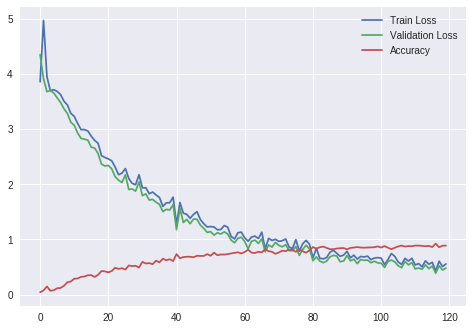

In [10]:
import matplotlib.pyplot as plt

plt.plot(stats['train_loss'], label='Train Loss')
plt.plot(stats['val_loss'], label='Validation Loss')
plt.plot(stats['acc'], label='Accuracy')
plt.legend()

### Testing model

Right!!
Label: Abraham Grampa Simpson
Prediction: Abraham Grampa Simpson


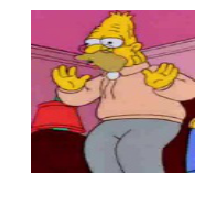

In [31]:
import warnings
warnings.filterwarnings('ignore')

#select random image
idx = random.randint(0, num_test_images)
sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
path_file = os.path.join(test_root_path, sample_file)
    
#read them
test_image = normalize(imresize(imread(path_file), (dim_size, dim_size)))
test_label_onehot = one_hot('_'.join(sample_name))[-1,:]

#move to tensors
test_image, test_label_onehot = torch.FloatTensor(test_image), torch.FloatTensor(test_label_onehot)

#permute image as (samples, x, y, channels) to (samples, channels, x, y)
test_image = test_image.permute(2, 0, 1)
test_image.unsqueeze_(0)

#move to GPU
test_image, test_label_onehot = test_image.to(device), test_label_onehot.to(device)


##
with torch.no_grad():
    output = net(test_image)
    predicted_character = torch.argmax(output.data, 1)
    actual_character = torch.argmax(test_label_onehot)
    print("Right!!") if (predicted_character == actual_character) else print("Wrong..")

    #showing
    actual_name = ' '.join([s.capitalize() for s in sample_name])
    print("Label: {}".format(actual_name))
    pred_name = lb.inverse_transform(output.cpu().numpy()).item() #copy from cuda to cpu, then to numpy
    prediction = ' '.join([s.capitalize() for s in pred_name.split('_')])
    print("Prediction: {}".format(prediction))

    plt.figure(figsize=(3,3))
    plt.imshow(test_image.permute(0, 2, 3, 1).squeeze())
    plt.axis('off')
    plt.show()